# Base Hopping using Brian Evaluation

In [1]:
import numpy as np
from brian2 import *
from brian2tools import *
from sympy import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Senstivity to Create The new system of Equations

In [2]:
def get_sensitivity_equations(group, parameters):
    eqs = group.equations
    diff_eqs = eqs.get_substituted_expressions(group.variables)
    diff_eq_names = [name for name, _ in diff_eqs]

    system = Matrix([diff_eq[1] for diff_eq in diff_eqs])
    J = system.jacobian(diff_eq_names)

    sensitivity = []
    sensitivity_names = []
    for parameter in parameters:
        F = system.jacobian([parameter])
        names = ['S_{}_{}'.format(diff_eq_name, parameter)
                 for diff_eq_name in diff_eq_names]
        sensitivity.append(J * Matrix(names) + F)
        sensitivity_names.append(names)

    new_eqs = []
    for names, sensitivity_eqs, param in zip(sensitivity_names, sensitivity, parameters):
        for name, eq, orig_var in zip(names, sensitivity_eqs, diff_eq_names):
            unit = eqs[orig_var].dim / group.namespace[parameter].dim
            new_eqs.append('d{lhs}/dt = {rhs} : {unit}'.format(lhs=name,
                                                           rhs=eq,
                                                           unit=repr(unit)))
    new_eqs = Equations('\n'.join(new_eqs))
    return new_eqs

## Neuron Example with 2 diff equ - AdEx

### Generate a step-current input and an "experimental" voltage trace

In [3]:
# Parameters
C = 171 * pF
# gL = 60 * nS
gL = 6.16243899e-08*siemens
taum = C / gL
EL = -65 * mV
VT = -50.4 * mV
DeltaT = 5 * mV
Vcut = VT + 50 * DeltaT
dt = 0.01*ms


In [4]:
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*2*nA
I = TimedArray(input_current, dt=dt)
defaultclock.dt = dt

In [5]:
start_scope()

In [6]:
taum

2.77487534 * msecond

In [7]:
tauw, a, b, Vr = 124*ms, 4*nS, 0.0805*nA, -70.6*mV 

In [25]:
# taum = C / gL : second

eqs = Equations( """
dvm/dt = (gL*(EL - vm) + gL*DeltaT*exp((vm - VT)/DeltaT) + I(t) - w)/C : volt
dw/dt = (a*(vm - EL) - w)/tauw : amp
""",
# gL= 6.16243899e-08*siemens
               )

In [26]:
neuron = NeuronGroup(1, model=eqs, threshold='vm>Vcut',
                     reset="vm=Vr; w+=b", method='exponential_euler')
neuron.vm = EL

In [28]:
# neuron.set_states({'gL':6.16243899e-08*siemens})

In [29]:
trace = StateMonitor(neuron, 'vm', record=0)
spikes = SpikeMonitor(neuron)

In [30]:
run(30*ms)

In [31]:
trace[0].vm/mV

array([-65.        , -64.99902993, -64.99806316, ..., -65.91632577,
       -65.91628874, -65.91625149])

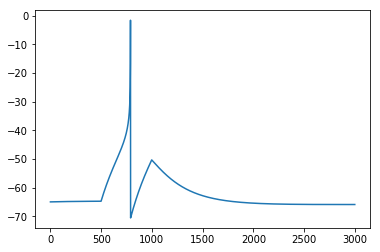

In [32]:
plt.plot(trace[0].vm/mV);

In [33]:
new_equ = get_sensitivity_equations(neuron, 'gL')

TypeError: 'ImaginaryUnit' object is not callable